# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [5]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [6]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [7]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [8]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [9]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [10]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [11]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [13]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [14]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [15]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [16]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [17]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [18]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [19]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

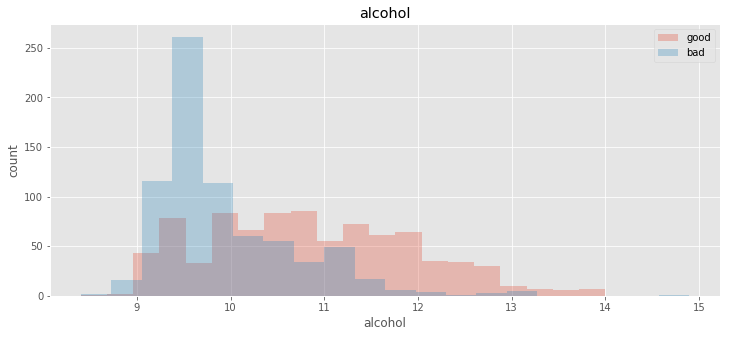

In [20]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [21]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [22]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [23]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [24]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [25]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [26]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [27]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [28]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [29]:
from sklearn.base import ClusterMixin

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=3, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        
        self.init = init
    
    def good_init(self, X):
        
        #первый центроид задается рандомной точкой
      
        self.centroids[0] = X[np.random.randint(0, X.shape[0])]
        
        
        for kl in xrange(self.k - 1):
            sum2x = 0
            
            #считаю суммму квадратов расстояний от точек до этого центроида
            for x_numb in xrange(X.shape[0]):
                sum2x += np.linalg.norm(self.centroids[kl] - X[x_numb])**2
                
            Rnd = np.random.uniform(0.0, 1.0) * sum2x
            
            sum2x = 0
            #снова подсчитываю сумму до тех пор, пока сумма не превысит Rnd
            for x_numb in xrange(X.shape[0]):
                sum2x += np.linalg.norm(self.centroids[kl] - X[x_numb])**2
                if sum2x > Rnd:
                    break
            
            #берем текущую точку в качестве центроида
            self.centroids[kl+1] = X[x_numb]
        
        return self

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        if self.init == 'k-means':
            self.good_init(X)
        else:
            for kl in xrange(self.k):
                self.centroids[kl] = X[kl]
            
        curr_iter = 0
    
        while curr_iter < self.max_iter:
            self.flag = 0
            #нахожу кластер, к которому принадлежит каждая точка
            for x_numb in xrange(X.shape[0]):
                temp = self.labels[x_numb].copy()
                self.labels[x_numb] = np.argmin(np.array([np.linalg.norm(self.centroids[kl] - X[x_numb]) for kl in range(self.k)]))
                if temp != self.labels[x_numb]:
                    self.flag = 1
            #если ничего не меняется, кластеризация закончена
            if self.flag == 0:
                break
            
            #перемещаю центроиды
            centroids2 = self.centroids.copy()
            for kl in xrange(self.k):
                i = 0
                centroids2[kl] = 0
                for x_numb in xrange(X.shape[0]):
                    if self.labels[x_numb] == kl:
                        i += 1
                        centroids2[kl] += X[x_numb]
                        
                if i != 0:
                    self.centroids[kl] = centroids2[kl]/i
            curr_iter += 1
            
        y = self.labels
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """

        
class MiniBatchKMeans(Kmeans):
    
    def __init__(self, k=3, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        
        self.init = init
        self.batch = self.k * 20
    
    def good_init(self, X):
        #первый центроид задается рандомной точкой
      
        self.centroids[0] = X[np.random.randint(0, X.shape[0])]
        
        
        for kl in xrange(self.k - 1):
            sum2x = 0
            
            #считаю суммму квадратов расстояний от точек до этого центроида
            for x_numb in xrange(X.shape[0]):
                sum2x += np.linalg.norm(self.centroids[kl] - X[x_numb])**2
                
            Rnd = np.random.uniform(0.0, 1.0) * sum2x
            
            sum2x = 0
            #снова подсчитываю сумму до тех пор, пока сумма не превысит Rnd
            for x_numb in xrange(X.shape[0]):
                sum2x += np.linalg.norm(self.centroids[kl] - X[x_numb])**2
                if sum2x > Rnd:
                    break
            
            #берем текущую точку в качестве центроида
            self.centroids[kl + 1] = X[x_numb]
            
        return self
    
    def fit(self, X, y=None):
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        
        if self.init == 'k-means':
            self.good_init(X)
        else:
            for kl in xrange(self.k):
                self.centroids[kl] = X[kl]
                
        curr_iter = 0
        while curr_iter < self.max_iter:
            self.flag = 0
            #выбираем из Х рандомно batch точек
            rand_x = np.random.choice(xrange(X.shape[0]), self.batch, False)
                           
            self.flag = 0
            #нахожу кластер, к которому принадлежит каждая точка
            for x_numb in rand_x:
                temp = self.labels[x_numb].copy()
                self.labels[x_numb] = np.argmin(np.array([np.linalg.norm(self.centroids[kl] - X[x_numb]) for kl in range(self.k)]))
                if temp != self.labels[x_numb]:
                    self.flag = 1
            #если ничего не меняется, кластеризация закончена
            if self.flag == 0:
                break
            
            #перемещаю центроиды
            centroids2 = self.centroids.copy()
            for kl in xrange(self.k):
                i = 0
                centroids2[kl] = 0
                for x_numb in rand_x:
                    if self.labels[x_numb] == kl:
                        i += 1
                        centroids2[kl] += X[x_numb]
                        
                if i != 0:
                    self.centroids[kl] = centroids2[kl]/i
            curr_iter += 1
        return self;
          

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [30]:
from sklearn.datasets import make_blobs

In [31]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=13)

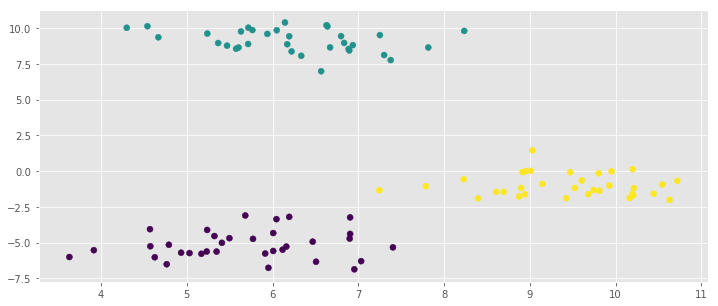

In [32]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

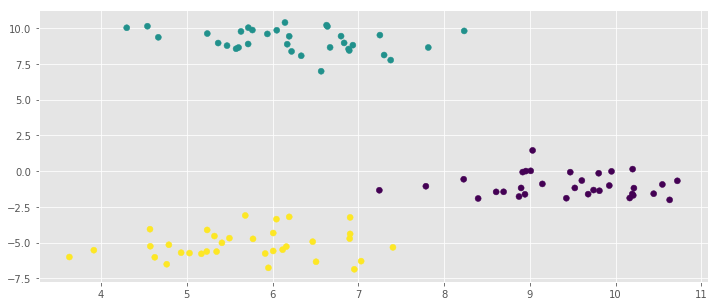

In [33]:
## Работоспособность KMeans
klast1 = Kmeans(3, 'euclidean', 1000, None, 'random')
klast1.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=klast1.labels)

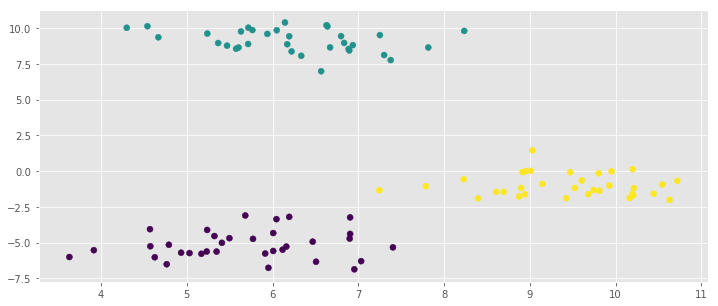

In [34]:
## Работоспособность KMeans++
klast2 = Kmeans(3, 'euclidean', 1000, None, 'k-means')
klast2.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=klast2.labels)

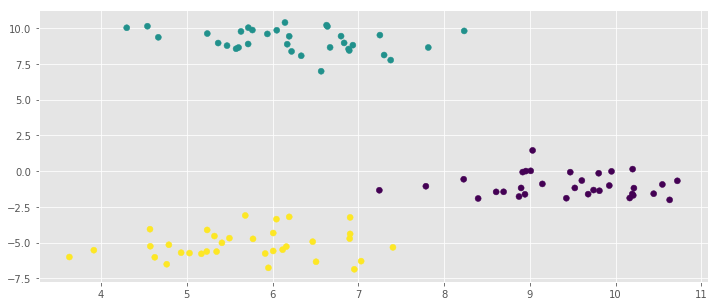

In [35]:
## Работоспособность KMeans с MiniBatchKMeans
klast3 = MiniBatchKMeans(3, 'euclidean', 1000, None, 'random')
klast3.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=klast3.labels)

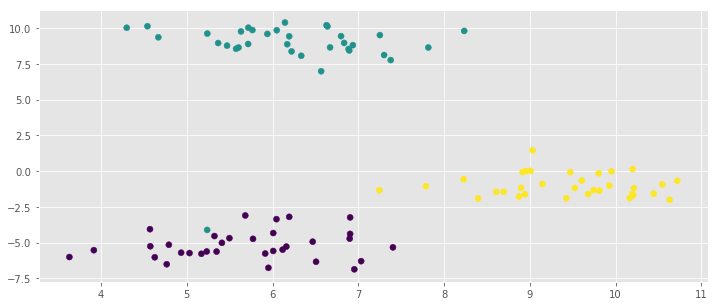

In [36]:
## Работоспособность KMeans++ с MiniBatchKMeans
klast4 = MiniBatchKMeans(3, 'euclidean', 1000, None, 'k-means')
klast4.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=klast4.labels)

Coeff:  0.146490693092


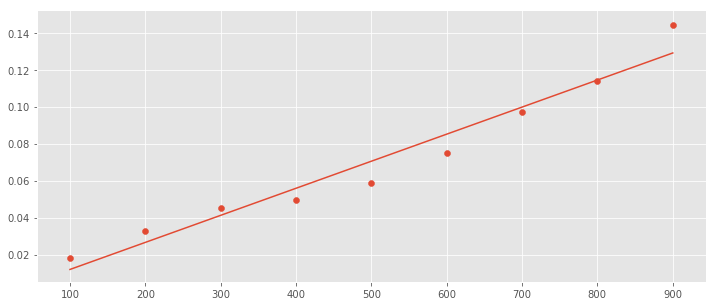

In [37]:
## Время выполнения алгоритма KMeans
import timeit

kmeans_time = np.empty((0, ))
for i in range(100, 1000, 100):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    result = %timeit -o -q -n 1 -r 1 klast1.fit(X,y)
    kmeans_time = np.append(kmeans_time, result.best)

x_values = np.array([x for x in range(100, 1000, 100)])
a, b = np.polyfit(x_values, kmeans_time, 1)
plt.plot(x_values, a * x_values + b, '-')
plt.scatter([x for x in range(100, 1000, 100)], kmeans_time)
print 'Coeff: ', a*1000

Coeff:  0.0959505240122


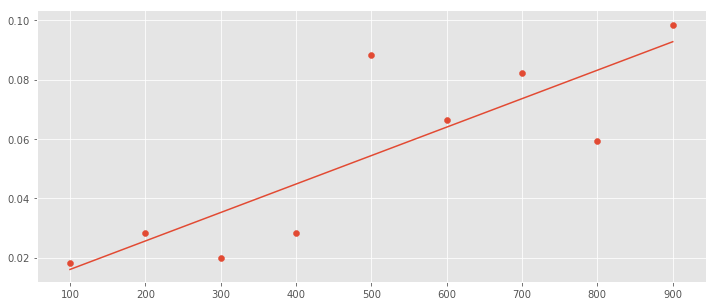

In [38]:
## Время выполнения алгоритма KMeans++
kmeans_time = np.empty((0, ))
for i in range(100, 1000, 100):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    result = %timeit -o -q -n 1 -r 1 klast2.fit(X,y)
    kmeans_time = np.append(kmeans_time, result.best)

x_values = np.array([x for x in range(100, 1000, 100)])
a, b = np.polyfit(x_values, kmeans_time, 1)
plt.plot(x_values, a * x_values + b, '-')
plt.scatter([x for x in range(100, 1000, 100)], kmeans_time)
print 'Coeff: ', a*1000

Coeff:  0.0658729871114


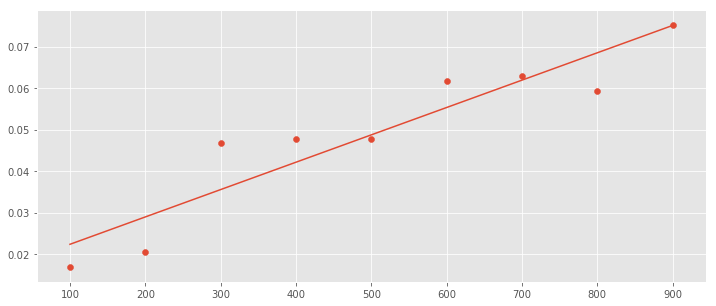

In [39]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
kmeans_time = np.empty((0, ))
for i in range(100, 1000, 100):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    result = %timeit -o -q -n 1 -r 1 klast3.fit(X,y)
    kmeans_time = np.append(kmeans_time, result.best)

x_values = np.array([x for x in range(100, 1000, 100)])
a, b = np.polyfit(x_values, kmeans_time, 1)
plt.plot(x_values, a * x_values + b, '-')
plt.scatter([x for x in range(100, 1000, 100)], kmeans_time)
print 'Coeff: ', a*1000

Coeff:  0.0600966215134


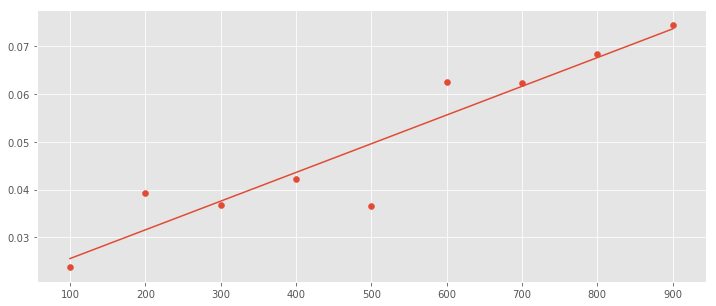

In [40]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
kmeans_time = np.empty((0, ))
for i in range(100, 1000, 100):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    result = %timeit -o -q -n 1 -r 1 klast4.fit(X,y)
    kmeans_time = np.append(kmeans_time, result.best)

x_values = np.array([x for x in range(100, 1000, 100)])
a, b = np.polyfit(x_values, kmeans_time, 1)
plt.plot(x_values, a * x_values + b, '-')
plt.scatter([x for x in range(100, 1000, 100)], kmeans_time)
print 'Coeff: ', a*1000

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [41]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()


,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [42]:
del df_sns['gradyear']
del df_sns['gender']
del df_sns['age']
del df_sns['friends']

In [43]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_sns.loc[:, ].values

In [44]:
#нормализация данных
emb = (emb - emb.mean(axis=0)[np.newaxis,:]) / emb.std(axis=0)[np.newaxis,:]

In [45]:
emb[emb < 0] = 0 ##xyu

In [46]:
## KMeans
klast5 = Kmeans(9, 'euclidean', 1000, None, 'random')
klast5.fit(emb, None)

Kmeans(init='random', k=9, max_iter=1000, metric='euclidean',
    random_state=None)

In [47]:
##ищем 3 максимальных координаты у центроидов, характеризующих кластер

for i in xrange(9):
    print np.argpartition(-klast5.centroids[i],3)[:3]

[28  1  6]
[25 28 10]
[23 22 20]
[ 1 28 10]
[14 35 24]
[17 16 18]
[31 28 30]
[4 3 0]
[28 18 20]


In [48]:
'''
0: softball, football, soccer - sports
1: dress, blonde, shopping - style
2: god, jesus, bible - religion
3: death, drugs, drunk - unhealthy lifestyle
4: hair, kissed, music - nightclub
5: music, marching, band - music
6: hollister, abercrombie, shopping - shopping
7: mall, hot, shopping - products shopping
8: blonde, tennis, swimming - girl's lifestyle
Вывод: однозначно делит на кластеры
'''

'\n0: shopping, dance, music, god, football\n1: music, hair, shopping, god, dance\n2: band, music, marching, god, rock\n3: shopping, cute, music, god, dance\n4: music, hair, kissed, sex, die\n5: music, god, shopping, rock, football\n6: shopping, mall, cute, music, god \n7: music, sex, hair, god, rock\n8: basketball, god, soccer, football, shopping\n'

In [202]:
## KMeans++
klast6 = Kmeans(9, 'euclidean', 1000, None, 'k-means')
klast6.fit(emb, None)

Kmeans(init='k-means', k=9, max_iter=1000, metric='euclidean',
    random_state=None)

In [203]:
for i in xrange(9):
    print np.argpartition(-klast6.centroids[i],3)[:3]
print klast6.labels

[3 1 6]
[12 10 32]
[16 17 18]
[31 30 22]
[24 29 14]
[13 27 35]
[25 27 28]
[26  5 20]
[10 15 32]
[ 7.  6.  7. ...,  7.  7.  7.]


In [ ]:
'''
0: softball, football, cheerleading - sports
1: sexy, cute, death - unhealthy lifestyle
2: band, marching, music - music
3: abercrombie, hollister, jesus - shopping
4: hair, clothes, kissed - nightclub
5: hot, clothes, drugs - ?
6: dress, clothes, shopping - style
7: blonde, swimming, god - girl's lifestyle
8: cute, dance, die - ?
Вывод: однозначно делит на кластеры, но немного отличается от предыдущей 
реализации
'''

In [50]:
## KMeans с MiniBatchKMeans
klast7 = MiniBatchKMeans(9, 'euclidean', 100, None, 'random')
klast7.fit(emb, None)

MiniBatchKMeans(init='random', k=9, max_iter=100, metric='euclidean',
        random_state=None)

In [51]:
for i in xrange(9):
    print np.argpartition(-klast7.centroids[i],3)[:3]

[20 22 23]
[29 14 24]
[16 17 32]
[26 11 34]
[20 24 18]
[11 30 24]
[21 11 33]
[11 24 32]
[28 15 27]


In [ ]:
'''
0: die, dance, hair
1: cute, volleyball, baseball
2: dress, mall, basketball
3: rock, sexy, music
4: clothes, hair, drugs
5: blonde, kissed, drunk
6: dress, abercrombie, music
7: band, marching, blonde
8: swimming, mall, hollister
Вывод: неоднозначно делит
'''

In [180]:
## KMeans++ с MiniBatchKMeans
klast8 = MiniBatchKMeans(9, 'euclidean', 1000, None, 'k-means')
klast8.fit(emb, None)


MiniBatchKMeans(init='k-means', k=9, max_iter=1000, metric='euclidean',
        random_state=None)

In [238]:
for i in xrange(9):
    print np.argpartition(-klast8.centroids[i],3)[:3]

[12 19 25]
[10 28  5]
[23 21  5]
[20 10 28]
[26 33 11]
[23 22 20]
[ 1 14 27]
[34 14 11]
[24 30 14]


In [ ]:
'''
0: sexy, rock, dress
1: cute, shopping, swimming
2: bible, church, swimming
3: god, cute, shopping
4: blonde, death, sex
5: bible, jesus, god
6: football, kissed, mall
7: drunk, kissed, sex
8: hair, hollister, kissed
Вывод: неоднозначно делит
'''

In [ ]:
## Вывод
'''
На мой взгляд, однозначно выделить лучший алгоритм нельзя

Между KMeans и KMeans++ стоит выбрать KMeans++, так как он обеспечивает 
большую скорость работы

Между  KMeans++ с MiniBatch и без нужно выбирать с MiniBatch, 
если скорость работы предпочтичтительнее точности.
В силу случайности выборки в MiniBatch может случиться такая ситуация, что
выборка будет неполной и некоторые точки будут прокластеризированы неправильно
В то же время обычный KMeans++ такой проблемы лишен, 
но вычисления занимают больше времени
'''

Вывод для кластеров для KMeans:
0: sex, hair, kissed, music, drunk
1: blond, sex, hair, drunk, god
2: sex, hair, shopping, rock, kissed
3: church, sex, death, rock, music
4: hair, god, music, bible, marching
5: rock, cute, music, hair, tennis
6: 
7: 
8: death, softball, church, band, 